# Variational AutoEncoder (VAE)

In [1]:
# Bisogna testare tutto passo passo
# Train Validation Test? Intendo, ci interessa la performance su dati Mai Visti?
# Plottare le qntà interessanti durante l'allenamento
# indagare #e loss e ottimizzatori

In [2]:
import torch
from torch import nn
from torch import optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [3]:
# work on GPUs?
# device = torch.device("cuda:0" if torch.cuda_is_available() alse "cpu")

In [4]:
## Import Dataset (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),                             
    # <-- we dont normalize here, can you guess why?
])

train_dataset = torchvision.datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
validation_dataset = torchvision.datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

In [5]:
# get rid of the labels (targets)

In [6]:
## Reduce dataset size
# N_TRAIN = 1000
# train_dataset.data, train_dataset.targets = train_dataset.data[:N_TRAIN], train_dataset.targets[:N_TRAIN]
# validation_dataset.data, validation_dataset.targets = validation_dataset.data[:N_TRAIN], validation_dataset.targets[:N_TRAIN]

BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False)

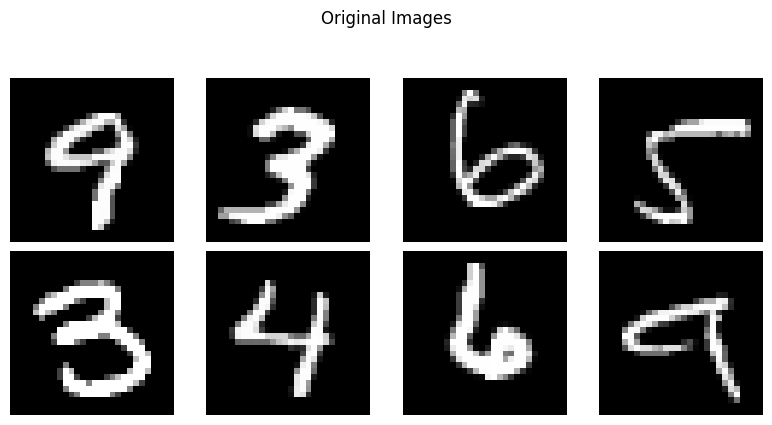

In [7]:
## Plotting utility
def plot_images(images, title):
    plt.figure(figsize=(8, 4)) # they're inches...
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title, y=1.05)
    plt.tight_layout()


with torch.no_grad():
    idx, (images, _) = next(enumerate(train_loader))

plot_images(images, title="Original Images")
plt.show()

In [8]:
# test cell
ex = enumerate(validation_loader)
id, (a, b) = next(ex)

In [36]:
# build model
# adesso è 1 autoencoder e basta, va reso probabilistico
class VAE(nn.Module):
    def __init__(self, input_dim, out_dim, latent_dim):
        super().__init__()
        self.flatten = nn.Flatten(1,3)
        ## interpolate middle layer dimension
        self.encoder_layer_1 = nn.Linear(input_dim, 256)
        self.activation1 = nn.ReLU()
        self.encoder_layer_2 = nn.Linear(256, latent_dim)
        self.activation2 = nn.ReLU()
        
        ## latent space
        
        self.decoder_layer_1 = nn.Linear(latent_dim, 128)
        self.activation3 = nn.ReLU() 
        self.decoder_layer_2 = nn.Linear(128, out_dim)
        self.sigmoid = nn.Sigmoid()
        self.unflatten = nn.Unflatten(1, (1, 28, 28))

    def encode(self, x):
        x = self.flatten(x)
        x = self.encoder_layer_1(x)
        x = self.activation1(x)
        x = self.encoder_layer_2(x)
        z = self.activation2(x)

        return z

    def decode(self, z):
        z = self.decoder_layer_1(z)
        z = self.activation3(z)
        z = self.decoder_layer_2(z)
        x_gen = self.sigmoid(z)
        x_gen = self.unflatten(x_gen)

        return x_gen

    def forward(self, x):
        z = self.encode(x)
        x_gen = self.decode(z)

        return x_gen

latent_dim = 32
model = VAE(28*28, 28*28, latent_dim)
# model = model.to(device)

In [10]:
print(model.parameters)

<bound method Module.parameters of VAE(
  (flatten): Flatten(start_dim=1, end_dim=3)
  (encoder_layer_1): Linear(in_features=784, out_features=128, bias=True)
  (activation1): ReLU()
  (encoder_layer_2): Linear(in_features=128, out_features=32, bias=True)
  (activation2): ReLU()
  (decoder_layer_1): Linear(in_features=32, out_features=128, bias=True)
  (activation3): ReLU()
  (decoder_layer_2): Linear(in_features=128, out_features=784, bias=True)
  (sigmoid): Sigmoid()
  (unflatten): Unflatten(dim=1, unflattened_size=(1, 28, 28))
)>


In [37]:
# train setup
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),
                      lr = 1e-2,
                      weight_decay=1e-6)

In [ ]:
# train loop
EPOCHS = 15
loss_train = []
loss_validation = []

for epoch in range(EPOCHS):
    loss_epoch = 0.0
    for batch, _ in train_loader:
        x_gen = model(batch) # in qlche modo qua sa che deve andare a prendere .forward()
        computed_loss = loss(x_gen, batch)
        loss_epoch += computed_loss.detach()
        
        optimizer.zero_grad()
        computed_loss.backward()
        optimizer.step()

    ## append loss (in alternativa prendi la media sui batches, ma ok)
    loss_epoch /= len(train_loader)
    loss_train.append(loss_epoch)

    with torch.no_grad():
        for val, _ in validation_loader:
            x_gen_val = model(val)
            val_computed_loss = loss(x_gen_val, val)
            loss_validation.append(val_computed_loss.detach())
            
    print(f"Epoch: {epoch+1:2.0f} -- Train loss = {computed_loss:.5f} -- Val loss = {val_computed_loss:.5f}")
    

Epoch:  1 -- Train loss = 0.02150 -- Val loss = 0.02126
Epoch:  2 -- Train loss = 0.01948 -- Val loss = 0.01892
Epoch:  3 -- Train loss = 0.01851 -- Val loss = 0.01812
Epoch:  4 -- Train loss = 0.01573 -- Val loss = 0.01776
Epoch:  5 -- Train loss = 0.01523 -- Val loss = 0.01752
Epoch:  6 -- Train loss = 0.01733 -- Val loss = 0.01719
Epoch:  7 -- Train loss = 0.01774 -- Val loss = 0.01721


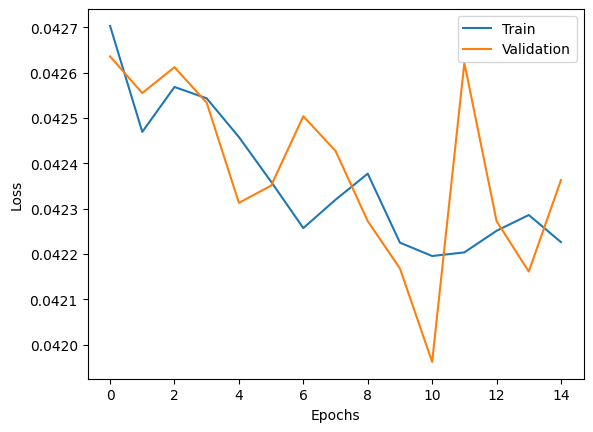

In [32]:
## Plot train and validation loss curves
plt.plot(loss_train, label = "Train")
plt.plot(loss_validation, label = "Validation")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

In [33]:
image_iterator = enumerate(train_loader)

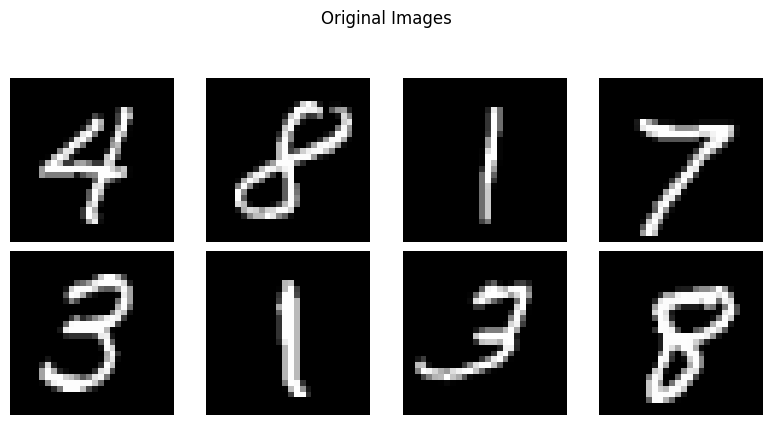

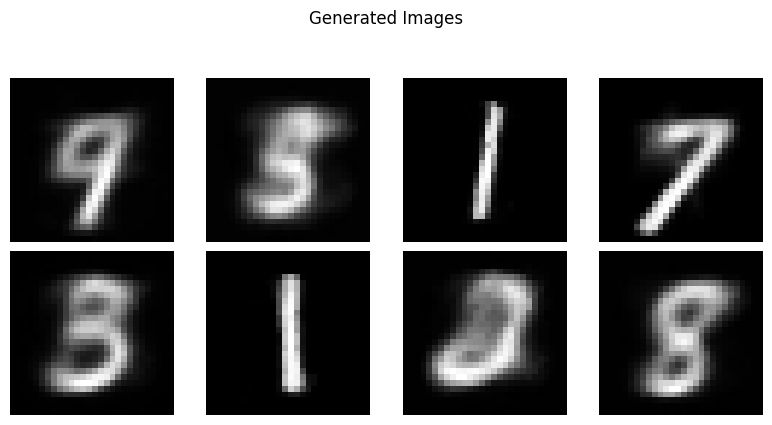

In [35]:
with torch.no_grad():
    idx, (images, _) = next(image_iterator)
    images_gen = model(images)
    

plot_images(images, title="Original Images")
plot_images(images_gen, title="Generated Images")
plt.show()